[Previous](https://github.com/biocore/gneiss/blob/master/ipynb/88soils.ipynb)

[Next](https://github.com/biocore/gneiss/blob/master/ipynb/ptsd_mice.ipynb)

In this study, there were 18 patients with cystic fibrosis.  The hypothesis was that there were two main communities at play in the CF lung.  One of these communities thrives at low pH, and the other community thrives at high pH.  To test this, sputum samples were divided among 8 tubes, and each of the tubes was perturbed with a different pH.  Here we will calculate balances, and test how these balances change with respect to pH, using linear mixed effects models.

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skbio.stats.composition import ilr, clr
from skbio import TreeNode, DistanceMatrix
from gneiss import mixedlm
from gneiss.sort import mean_niche_estimator, niche_sort, gradient_sort
from gneiss.util import match, rename_internal_nodes
from gneiss.balances import balance_basis, balanceplot

from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace, BarChartFace
import seaborn as sns
import matplotlib
from biom import load_table

from scipy.cluster.hierarchy import average
from scipy.spatial.distance import euclidean
from statsmodels.sandbox.stats.multicomp import multipletests
%matplotlib inline

/Users/mortonjt/miniconda3/envs/gneiss/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mortonjt/miniconda3/envs/gneiss/lib/python3.5/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
mapping = pd.read_table('data/cfstudy/10511_prep_1890_qiime_20160715-140210.txt', index_col=0)
table = load_table('data/cfstudy/otu_table.biom')

First, we'll want to drop all of the samples that do not have pH values.  Most of the samples that don't have these
values are blanks.  The healthy individuals will not be included either, since we are explicitly looking at the effects of pH on cystic fibrosis lungs.

In [3]:
# Drop sputum samples
mapping = mapping.dropna(subset=['ph']) 
# Drop healthy samples
mapping = mapping.loc[(mapping.healthy=='No').values]
# Drop samples without ph.  This will drop blanks
mapping = mapping.loc[mapping.ph != 'Not applicable']
mapping['ph'] = mapping.ph.astype(np.float64)

Again, we'll want to filter out low abundance OTUs.  This will not only remove potential confounders, but could also alleviate the issue with zeros. 

In [4]:
sample_filter = lambda val, id_, md: sum(val) > 2000
read_filter = lambda val, id_, md: sum(val) > 500

md_filter = lambda val, id_, md:  id_ in mapping.index
table.filter(md_filter, axis='sample')
table.filter(sample_filter, axis='sample')
table.filter(read_filter, axis='observation')

127 x 135 <class 'biom.table.Table'> with 8552 nonzero entries (49% dense)

Then we'll want to relabel the patient numbers.  This is just to simplify the figures generated downstream.

In [5]:
# Let's number the patient numbers
h = np.unique(mapping.host_subject_id)
x = dict(zip(list(h), range(len(h))))
mapping['patient'] = [x[i] for i in mapping.host_subject_id]

In [6]:
def convert_biom_to_pandas(table):
    """ Unpacks biom table into two pandas dataframes.
    
    The first dataframe will contain the count information for 
    features and samples. The second datafram will contain taxonomy 
    information for all of the OTUs.
    
    Parameters
    ----------
    table : biom.Table
    
    Returns
    -------
    pd.DataFrame
        Contingency table of counts where samples correspond 
        to rows and columns correspond to features (i.e. OTUs)
    pd.DataFrame
        A mapping of OTU names to taxonomic ids
    """

    feature_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                             index=table.ids(axis='sample'),
                             columns=table.ids(axis='observation'))
    feature_ids = table.ids(axis='observation')
    mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in feature_ids}
    # modify below as necessary.  
    # There are typically 7 levels of taxonomy.
    taxonomy = pd.DataFrame(mapping, 
                            index=['kingdom', 'phylum', 'class', 'order', 
                                   'family', 'genus', 'species']).T
    return feature_table, taxonomy

Again, we'll use the [`match`](https://github.com/biocore/gneiss/blob/master/gneiss/util.py#L11) function to 
align the metadata table and the OTU table.

In [7]:
otu_table, taxonomy = convert_biom_to_pandas(table)
otu_table, mapping = match(otu_table, mapping)

We'll now define a function to sort the tips of the tree according to their preferred pH.  When hierarchical clustering is performed, the trees may not be rotated properly.  This function is to help straight the trees out for the sake of tree visualization later.

Again, we will create the tree using pH.  Note that we'll also want to reorder the OTU table for the balance calculations.

In [8]:
mean_ph = mean_niche_estimator(otu_table, gradient=mapping.ph)
dm = DistanceMatrix.from_iterable(mean_ph, euclidean)
lm = average(dm.condensed_form()) 
ph_tree = TreeNode.from_linkage_matrix(lm, otu_table.columns) 

# sort the tree tips according to mean pH
mean_ph = pd.Series(mean_ph, otu_table.columns)
ph_tree = gradient_sort(ph_tree, mean_ph)

Finally, we can run the linear mixed effects models using [`mixed`](https://github.com/biocore/gneiss/blob/master/gneiss/_formula.py#L247).  pH is the only covariate being tested for
and each of the patients are being accounted for by passing `host_subject_id` into `groups`.  A RegressionResults object will be returned summarizing the corresponding statistics of the balance tests.

Its important to note that `mixedlm` cannot handle OTU tables with zero counts.  Here we will be adding a pseudo count of 1, but there are many other options to explore for handling zeros, such as `skbio.stats.composition.multiplicative_replacement`.

In [9]:
res = mixedlm('ph', otu_table + 1, mapping, ph_tree, groups='host_subject_id')

/Users/mortonjt/miniconda3/envs/gneiss/lib/python3.5/site-packages/statsmodels/regression/mixed_linear_model.py:160: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._params = np.zeros(self.k_tot)


Just as a sanity check, we'll look at the bonferroni corrected pvalues of pH.  Note that the first 2 p-values actually rounded down to zero, suggesting that even with multiple hypothesis correction that these balances were determined to be significant according to the model.

In [10]:
reject, corrected_pvals, sidak, bonf = multipletests(res.pvalues.ph)
corrected_pvals[:10]

array([  0.00000000e+00,   0.00000000e+00,   9.99999852e-01,
         9.98694698e-01,   0.00000000e+00,   8.05281529e-01,
         9.99999852e-01,   9.99999852e-01,   5.28244115e-13,
         3.00123325e-01])

We can then visualize the pvalues on a tree, by decorating the internal nodes to represent the significance of the balances.

In [11]:
tr, ts = balanceplot(balances=-np.log(res.pvalues.ph), tree=res.tree, mode='r')  

The code to specify the layout of the tree is as follows.  All of the OTUs are colored by their preferred pH, and
balls are placed at the internal nodes to represent the pvalues on the balances.

In [12]:
norm_ph = (mean_ph - mean_ph.min()) / (mean_ph.max() - mean_ph.min())
cmap = plt.get_cmap('RdYlBu')
colors = pd.Series([matplotlib.colors.rgb2hex(cmap(1-i)) for i in norm_ph],
                   index=norm_ph.index)

def layout(node):
    """
    Specifies the layout for the ete.TreeStyle object.
    
    Parameters
    ----------
    node: ete.Tree
        Input node for specifying which attributes.
    """
    if node.is_leaf():
        # Add node name to leaf nodes
        taxa = ';'.join(taxonomy.loc[node.name].values) + '(%s)' % node.name
        node.taxa = taxa
        color_name = colors[node.name]
        N = AttrFace("taxa", fsize=15, fgcolor='black')
        N.background.color = color_name
        N.background.opacity = 0.1

        faces.add_face_to_node(N, node, 0)
        
    if "weight" in node.features:
        # Creates a sphere face whose size is proportional to node's
        # feature "weight"
        C = CircleFace(radius=node.weight/2, color="Red", style="sphere")
        # Let's make the sphere transparent
        C.opacity = 0.7
        # Rotate the faces by 90*
        C.rotation = 90
        # And place as a float face over the tree
        faces.add_face_to_node(C, node, 0, position="float")

        fsize = 18
        fgcolor = 'black'
        N = AttrFace("name", fsize=fsize, fgcolor=fgcolor)
        faces.add_face_to_node(N, node, 0)

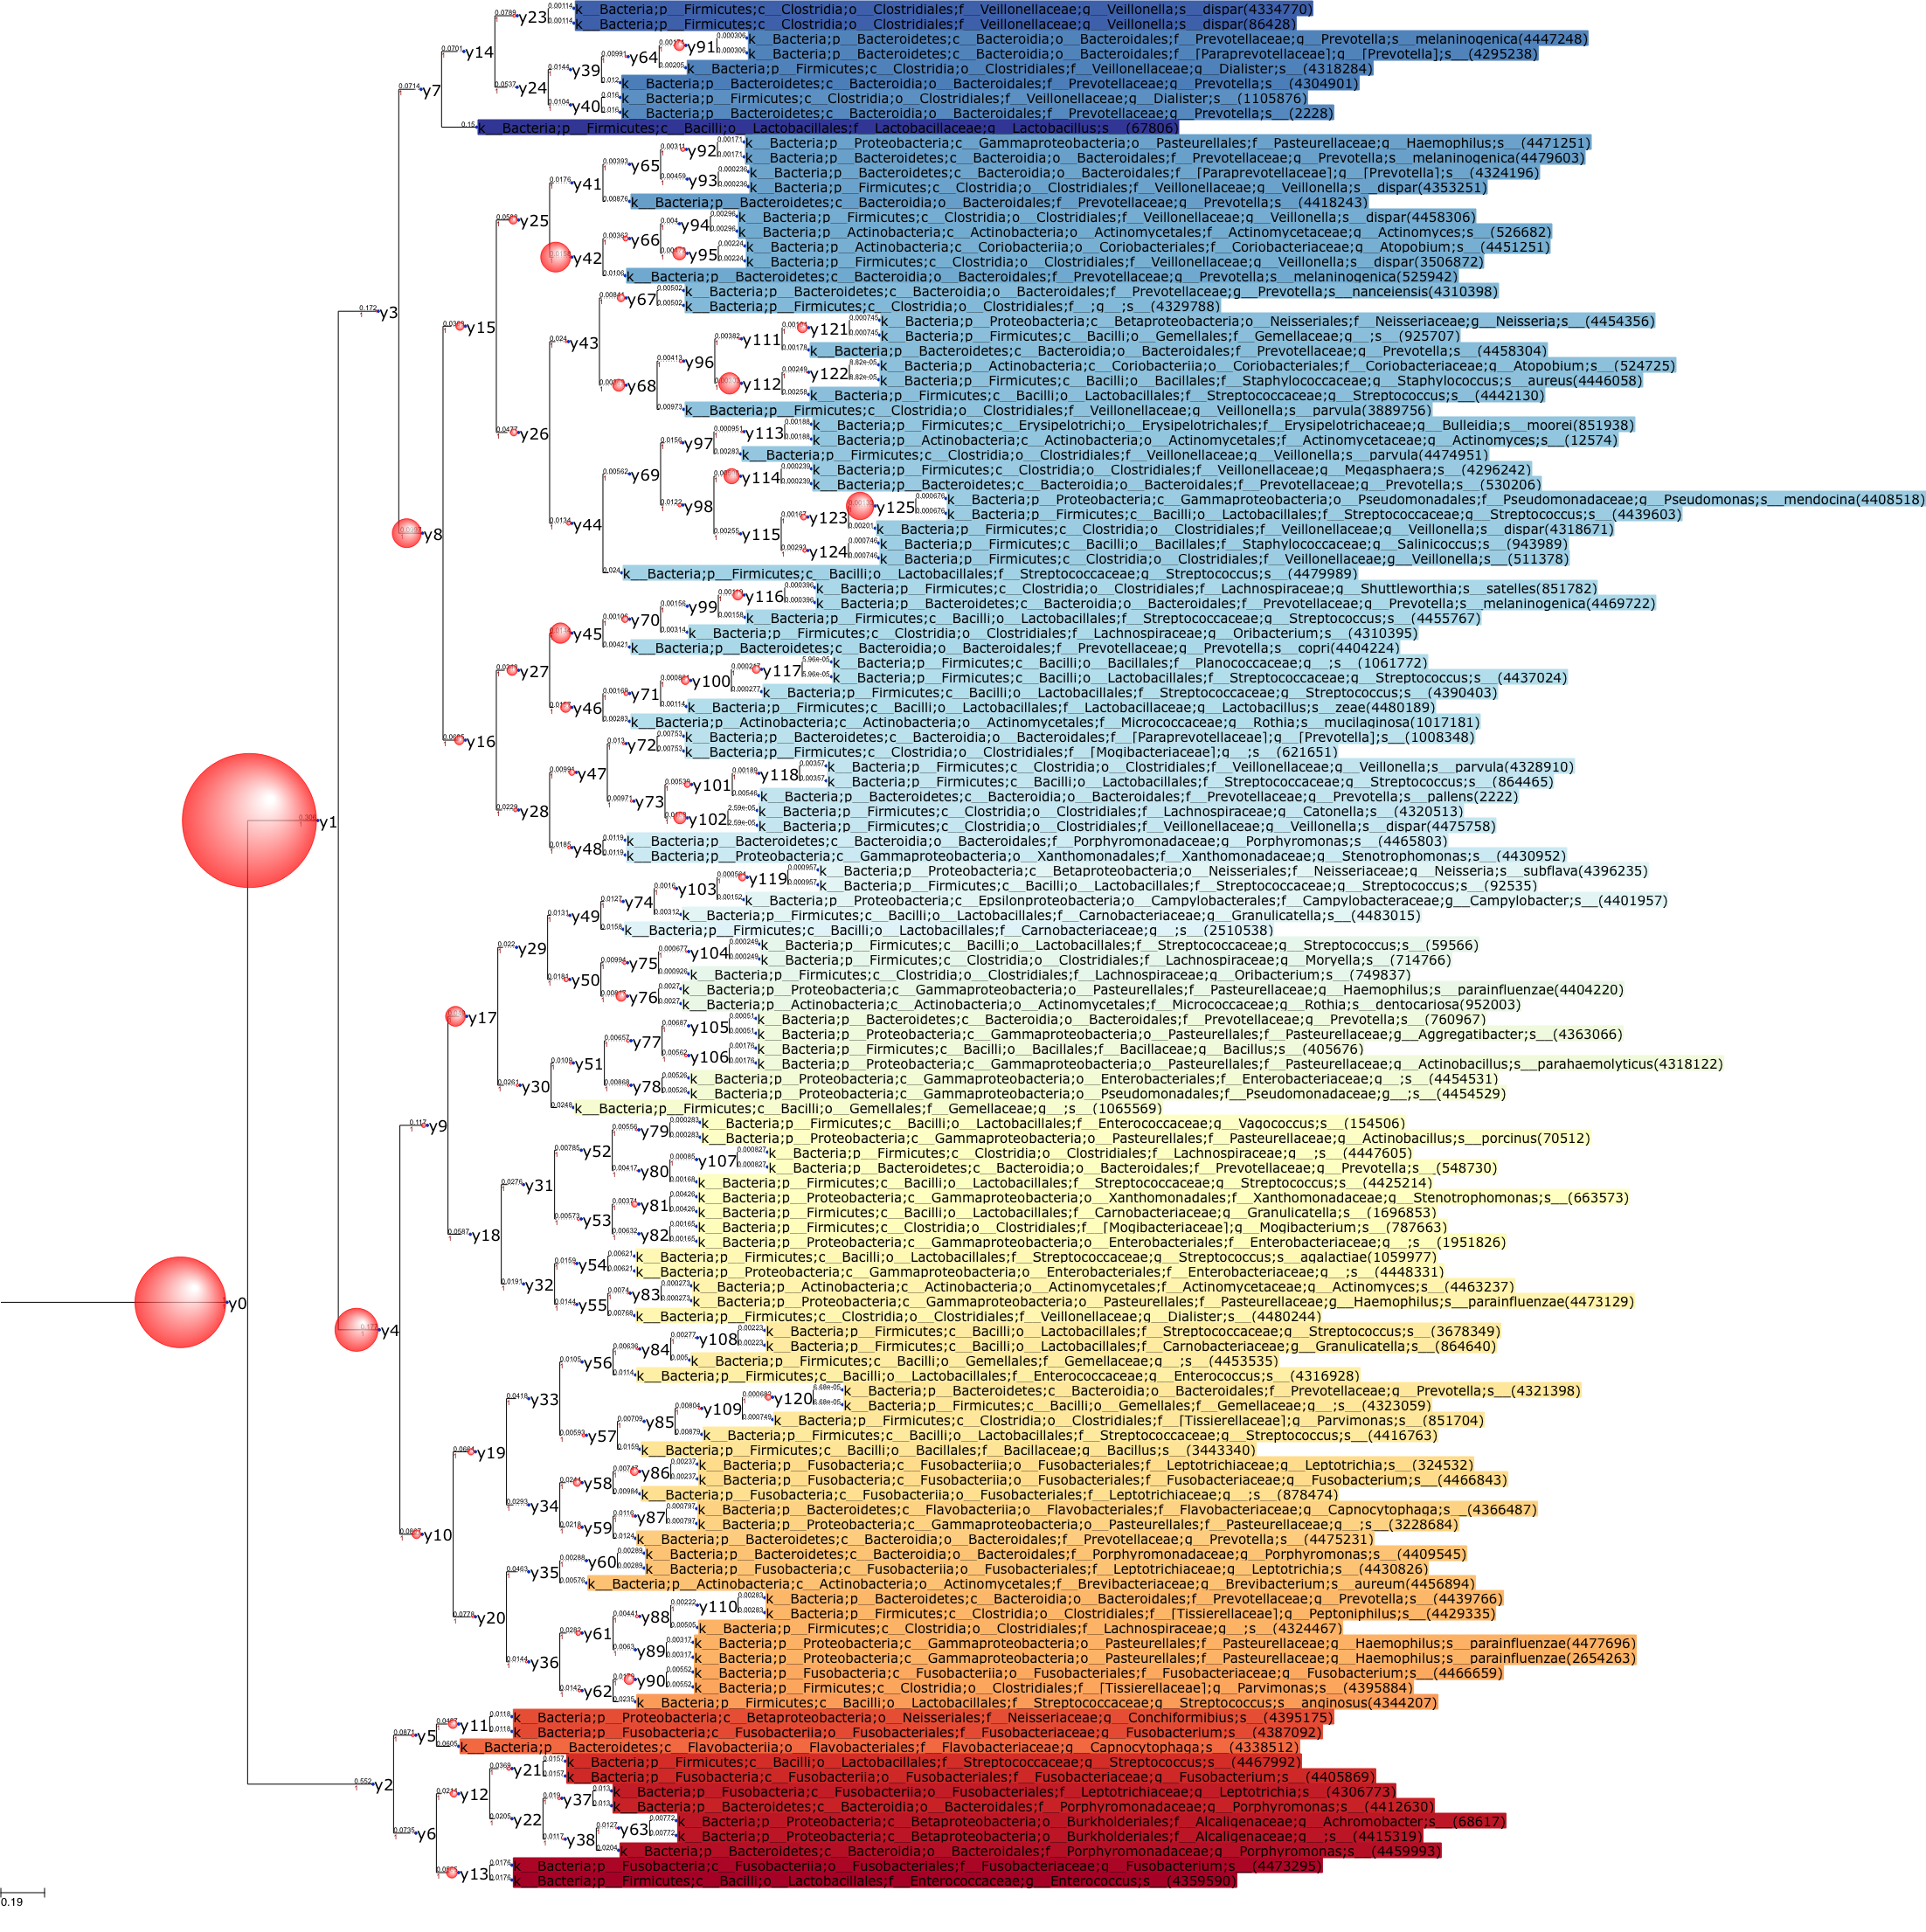

In [13]:
tr.render(file_name='%%inline', tree_style=ts, layout=layout)

Of course, it is generally considered bad practice to take p-values at face value.  So we'll look directly at the top 2 balances for all of the samples.

In [14]:
basis, nodes = balance_basis(ph_tree)
balances = res.balances
data = pd.merge(balances, mapping, left_index=True, right_index=True)

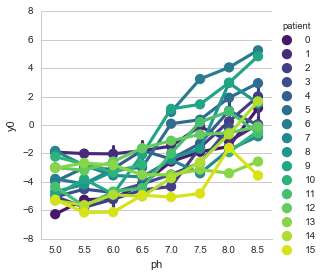

In [15]:
sns.set(style="whitegrid")
grid = sns.factorplot(x="ph", y="y0", hue='patient', data=data, palette="viridis") 

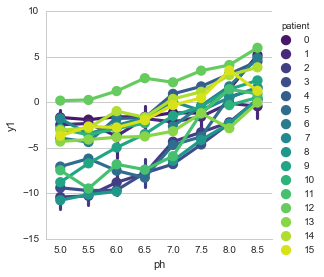

In [16]:
grid = sns.factorplot(x="ph", y="y1", hue='patient', data=data, palette="viridis") 

From these plots, it looks like all of the patients are following the same sort of trend. 

The main message to take away from this, is that every patient has different microbes, so it is difficult to test for individual microbes abundances across patients.  However, every patient has microbes that behave the same with respect to pH.  Balances is a very powerful tool for addressing this, as it can allow for entire subcommunities to be tested, rather than just individual OTUs.